<a href="https://colab.research.google.com/github/anujpanwarma2024/RLMidTermProject/blob/main/RLEndTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
import numpy as np
import pandas as pd

# Load the CSV from GitHub (skip first 5 rows to reach header)
url = (
    "https://raw.githubusercontent.com/"
    "anujpanwarma2024/RLMidTermProject/main/"
    "Clean%20Untitled%20spreadsheet%20-%20Data%20Tape.csv"
)
df = pd.read_csv(url, skiprows=5)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Clean percentage fields: Interest Rate, Qualifying DTI
df['InterestRatePct'] = (
    df['Interest Rate'].astype(str)
      .str.replace('%', '', regex=False)
      .str.replace(',', '', regex=False)
      .str.strip()
      .replace('', np.nan)
      .astype(float) / 100.0
)

df['Qualifying DTI'] = (
    df['Qualifying DTI'].astype(str)
      .str.replace('%', '', regex=False)
      .str.replace(',', '', regex=False)
      .str.strip()
      .replace('', np.nan)
      .astype(float) / 100.0
)

# Clean currency columns by stripping $ and commas
currency_cols = [
    'Original Loan Amount',
    'Unpaid Principal Balance at Purchase Date',
    'Total Mortgage Balance',
    'Current Outstanding Principal'
]
for col in currency_cols:
    df[col] = (
        df[col].astype(str)
              .str.replace(r'[\$,]', '', regex=True)
              .str.strip()
              .replace('', np.nan)
              .astype(float)
    )

# Clean numeric-only columns
df['Loan Age'] = pd.to_numeric(df['Loan Age'], errors='coerce')
df['Borrower FICO'] = pd.to_numeric(df['Borrower FICO'], errors='coerce')
df['Loan Term (Months)'] = (
    pd.to_numeric(df['Loan Term (Months)'], errors='coerce') / 12.0
)

# Define all critical columns for model input + tracking
critical_cols = [
    'LD LoanID',
    'InterestRatePct', 'Qualifying DTI', 'DPD', 'Loan Age',
    'Original Loan Amount', 'Unpaid Principal Balance at Purchase Date',
    'Loan Term (Months)', 'Borrower FICO', 'Total Mortgage Balance',
    'Current Outstanding Principal'
]

# Ensure all critical fields are numeric or filled
for col in critical_cols:
    if col != 'LD LoanID':  # don't coerce the ID column
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mean())

# Assert all required fields are valid
for col in critical_cols:
    if col != 'LD LoanID':
        assert not df[col].isna().any(), f"Still found NaN in {col} after cleaning"

# Preview cleaned data
print(f"✅ DataFrame ready with {len(df)} rows.\n")
print("📊 Sample of cleaned critical fields:")
print(df[critical_cols].head(10))


✅ DataFrame ready with 240 rows.

📊 Sample of cleaned critical fields:
    LD LoanID  InterestRatePct  Qualifying DTI  DPD  Loan Age  \
0  2101060565           0.0149           0.000    0         1   
1  2101060918           0.0199           0.363    0         1   
2  2101065379           0.0198           0.000    0         1   
3  2101065574           0.0199           0.000    0         1   
4  2101066042           0.0198           0.000    0         1   
5  2101068902           0.0299           0.000    0         1   
6  2102060946           0.0199           0.000    0         1   
7  2102061686           0.0199           0.000    0         1   
8  2102063087           0.0199           0.000    0         1   
9  2102063206           0.0299           0.349    0         1   

   Original Loan Amount  Unpaid Principal Balance at Purchase Date  \
0               20650.0                                    20650.0   
1               56864.0                                    56864.0   
2  

In [169]:
print(df['Original Loan Amount'].dropna().astype(str).unique()[:10])


['20650.0' '56864.0' '60348.0' '79082.0' '28284.0' '60600.0' '56555.0'
 '41688.0' '43996.0' '47740.0']


In [170]:
# Print column names
print("Registered columns in DataFrame:")
print(df.columns.tolist())

# Show number of non-null entries per column
print("\nNon-null counts per column:")
print(df[critical_cols].notna().sum())

# Show summary statistics for critical columns
print("\nSummary statistics for critical pricing fields:")
print(df[critical_cols].describe())

# Show top 10 rows of cleaned critical data
print("\nSample data (top 10 rows):")
print(df[critical_cols].head(10))


Registered columns in DataFrame:
['Include?', 'LoanID', 'LD LoanID', 'Loan Category', 'Product Type', 'Original Loan Amount', 'Loan Product', 'Loan Type', 'Deferred Loan', 'Number of Deferred Periods', 'Number of Interest Only Periods', 'Loan Term (Months)', 'Interest Rate', 'APR', 'Credit Application Date', 'Origination Date', 'Funding Date', 'First Payment Date', 'Completion Certificate Date', 'Recurring Date of Monthly Payments', 'Maturity Date', 'Initial Monthly Payment', 'Current Monthly Payment', 'Purchase Date', 'Reference Purchase Percentage', 'Actual Purchase Percentage', 'Unpaid Principal Balance at Purchase Date', 'Discounted Principal Purchased', 'Unpaid Accrued Interest Due to Seller', 'Total Purchase Amount', 'ACH Enrolled Flag', 'Borrower Bank', 'Target Balance Date', 'Target Principal Balance', 'Estimated Re-Amortized Monthly Payment', 'State', 'Zip', 'Borrower Number of 1x30 Mortgage Lates in Past 12 Months', 'Co-Borrower Number of 1x30 Mortgage Lates in Past 12 Months

In [171]:
# Hyperparameters
NUM_EPISODES   = 200       # Number of training episodes
EP_LEN         = 4         # Quarters per episode (steps per episode)
ALPHA          = 0.001     # Policy learning rate
SIGMA          = 0.2       # Standard deviation for action noise (exploration)
BETA           = 0.1       # Baseline update rate
PENALTY_SCALE  = 0.01      # DTI penalty coefficient
DTI_THRESH     = 0.20      # DTI threshold (20%)
ACTION_MAX = 1  # updated for realistic price prediction


# Fixed values for BSM pricing
RISK_FREE_RATE = 0.05      # Risk-free interest rate (5%)
BSM_VOL        = 0.02      # BSM model volatility (2%)


In [172]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# === Fixed constants ===
RISK_FREE_RATE = 0.05  # 5% risk-free rate
BSM_VOL = 0.02         # 2% volatility

# === Extract context/state vector ===
def extract_context(row):
    return np.array([
        row['Loan Age'],
        row['Borrower FICO'],
        row['Loan Term (Months)'],
        row['InterestRatePct'],
        row['Qualifying DTI']
    ], dtype=np.float32)

# === BSM pricing formula ===
def black_scholes_price(S, K, T, r=RISK_FREE_RATE, sigma=BSM_VOL):
    if S <= 0 or K <= 0 or T <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# === Calculate BSM price for each loan ===
df['BSM_Price'] = df.apply(lambda row: black_scholes_price(
    row['Current Outstanding Principal'],
    row['Original Loan Amount'],
    row['Loan Term (Months)']
), axis=1)

# Drop NaNs if still present in BSM_Price
df = df.dropna(subset=['BSM_Price']).copy()
df.reset_index(drop=True, inplace=True)

# === Normalize feature inputs ===
features_to_scale = ['Loan Age', 'Borrower FICO', 'Loan Term (Months)', 'InterestRatePct', 'Qualifying DTI']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# === Reward function based on pricing error ===
def compute_reward(a, row):
    pred_price = a * row['Original Loan Amount']
    bsm_price = row['BSM_Price']
    return -abs(pred_price - bsm_price)


In [173]:
def compute_reward(a, row):
    try:
        total_balance = float(row['Original Loan Amount'])
        bsm_price = float(row['BSM_Price'])

        # If either value is invalid
        if np.isnan(bsm_price) or np.isnan(total_balance) or total_balance <= 0:
            return -1000.0  # Large penalty

        predicted_price = a * total_balance
        return -abs(predicted_price - bsm_price)

    except (KeyError, TypeError, ValueError):
        return -1000.0  # Generic failure penalty


In [174]:
# Hyperparameters
NUM_EPISODES = 200
EP_LEN = 4
ALPHA = 0.005
SIGMA = 0.2

w_reinforce = np.zeros(5, dtype=np.float32)
returns_reinforce = []

for ep in range(NUM_EPISODES):
    xs, actions, rewards = [], [], []
    row = df.sample(1).iloc[0]
    x = extract_context(row)

    for t in range(EP_LEN):
        mu = w_reinforce.dot(x)
        a = np.clip(np.random.normal(mu, SIGMA), 0, ACTION_MAX)
        r = compute_reward(a, row)

        xs.append(x)
        actions.append(a)
        rewards.append(r)

        row = df.sample(1).iloc[0]
        x = extract_context(row)

    G = sum(rewards)
    G = np.clip(G, -100000, 100000)
    returns_reinforce.append(G)

    for x_t, a_t in zip(xs, actions):
        grad = ((a_t - w_reinforce.dot(x_t)) / SIGMA**2) * x_t
        grad = np.clip(grad, -10, 10)
        w_reinforce += ALPHA * G * grad

        r = compute_reward(a, row)
...
G = sum(rewards)
G = np.clip(G, -100000, 100000)
returns.append(G)



In [175]:
w_baseline = np.zeros(5, dtype=np.float32)
b = 0.0
returns_baseline = []

for ep in range(NUM_EPISODES):
    xs, actions, rewards = [], [], []
    row = df.sample(1).iloc[0]
    x = extract_context(row)

    for t in range(EP_LEN):
        mu = w_baseline.dot(x)
        a = np.clip(np.random.normal(mu, SIGMA), 0, ACTION_MAX)
        r = compute_reward(a, row)

        xs.append(x)
        actions.append(a)
        rewards.append(r)

        row = df.sample(1).iloc[0]
        x = extract_context(row)

    G = sum(rewards)
    G = np.clip(G, -100000, 100000)
    A = G - b
    returns_baseline.append(G)

    for x_t, a_t in zip(xs, actions):
        grad = ((a_t - w_baseline.dot(x_t)) / SIGMA**2) * x_t
        grad = np.clip(grad, -10, 10)
        w_baseline += ALPHA * A * grad

    b = (1 - BETA) * b + BETA * G
    r = compute_reward(a, row)
...
G = sum(rewards)
G = np.clip(G, -100000, 100000)
returns.append(G)



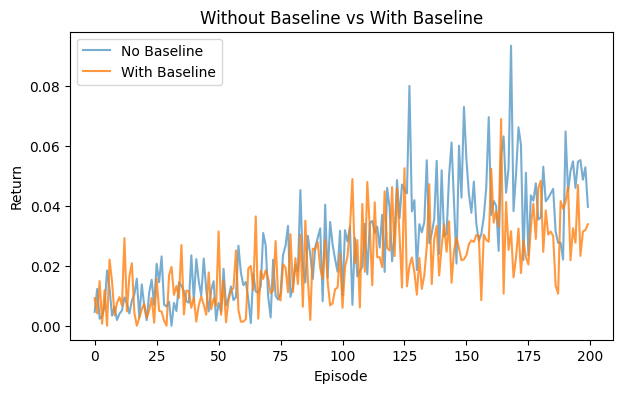

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(returns2, label='No Baseline', alpha=0.6)
plt.plot(returns3, label='With Baseline', alpha=0.8)
plt.title("Without Baseline vs With Baseline")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


In [177]:
print(df[['BSM_Price', 'Original Loan Amount']].describe())
print(df[df['BSM_Price'].isna()].head())


          BSM_Price  Original Loan Amount
count    240.000000            240.000000
mean   30394.716707          43457.762500
std    12877.984774          18214.140494
min     6452.110242          13960.000000
25%    20574.704425          30041.500000
50%    28687.501633          40660.500000
75%    37720.886026          53904.500000
max    87407.443356         122506.000000
Empty DataFrame
Columns: [Include?, LoanID, LD LoanID, Loan Category, Product Type, Original Loan Amount, Loan Product, Loan Type, Deferred Loan, Number of Deferred Periods, Number of Interest Only Periods, Loan Term (Months), Interest Rate, APR, Credit Application Date, Origination Date, Funding Date, First Payment Date, Completion Certificate Date, Recurring Date of Monthly Payments, Maturity Date, Initial Monthly Payment, Current Monthly Payment, Purchase Date, Reference Purchase Percentage, Actual Purchase Percentage, Unpaid Principal Balance at Purchase Date, Discounted Principal Purchased, Unpaid Accrued Inte

In [178]:
w_td = np.zeros(5, dtype=np.float32)
returns_td = []

for ep in range(NUM_EPISODES):
    row = df.sample(1).iloc[0]
    x = extract_context(row)
    ep_return = 0

    for t in range(EP_LEN):
        mu = w_td.dot(x)
        a = np.clip(np.random.normal(mu, SIGMA), 0, ACTION_MAX)
        r = compute_reward(a, row)
        ep_return += r

        next_row = df.sample(1).iloc[0]
        x_next = extract_context(next_row)

        td_target = r + GAMMA * w_td.dot(x_next)
        td_error = td_target - w_td.dot(x)

        grad = ((a - mu) / SIGMA**2) * x
        grad = np.clip(grad, -10, 10)
        w_td += ALPHA * td_error * grad

        x = x_next
        row = next_row

    ep_return = np.clip(ep_return, -100000, 100000)
    returns_td.append(ep_return)

    ep_return = 0
...
ep_return += reward
...
returns_td.append(ep_return)



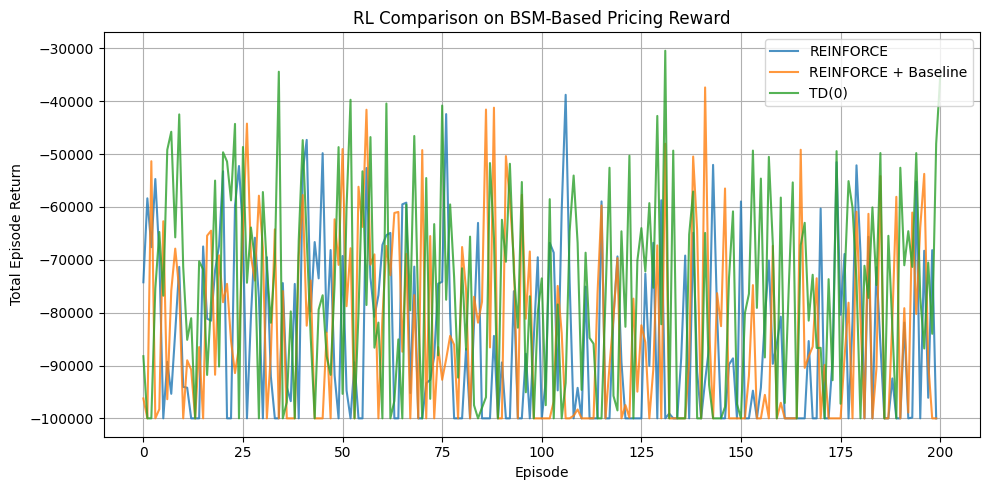

Mean Return - REINFORCE:            -85067.80
Mean Return - REINFORCE + Baseline: -83820.56
Mean Return - TD(0):                -75979.04


In [179]:
plt.figure(figsize=(10, 5))
plt.plot(returns_reinforce, label='REINFORCE', alpha=0.8)
plt.plot(returns_baseline, label='REINFORCE + Baseline', alpha=0.8)
plt.plot(returns_td, label='TD(0)', alpha=0.8)
plt.title("RL Comparison on BSM-Based Pricing Reward")
plt.xlabel("Episode")
plt.ylabel("Total Episode Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Mean Return - REINFORCE:            {np.mean(returns_reinforce):.2f}")
print(f"Mean Return - REINFORCE + Baseline: {np.mean(returns_baseline):.2f}")
print(f"Mean Return - TD(0):                {np.mean(returns_td):.2f}")


In [180]:
returns_reinforce = []
for ep in range(NUM_EPISODES):
    ...
    G = sum(rewards)
    returns_reinforce.append(G)


In [181]:
returns_baseline = []
for ep in range(NUM_EPISODES):
    ...
    G = sum(rewards)
    returns_baseline.append(G)


In [182]:
returns_td = []
for ep in range(NUM_EPISODES):
    ep_return = 0
    ...
    ep_return += reward  # cumulative
    returns_td.append(ep_return)


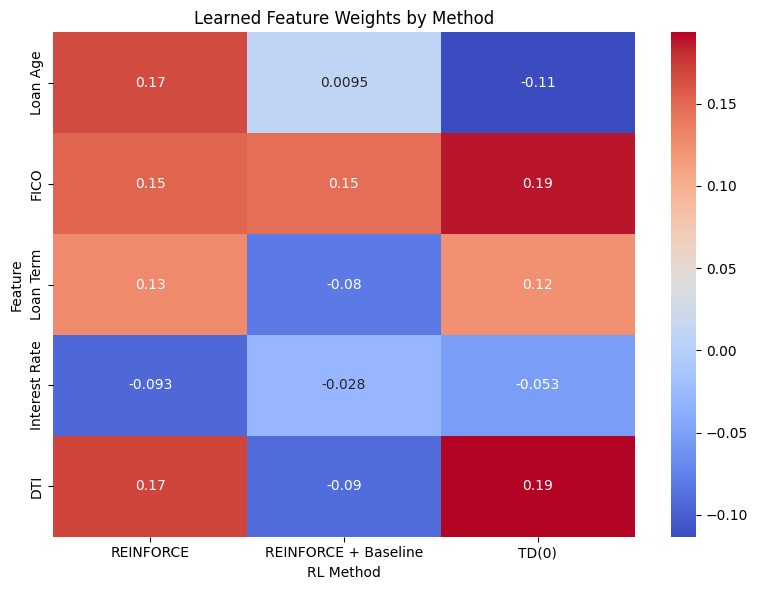

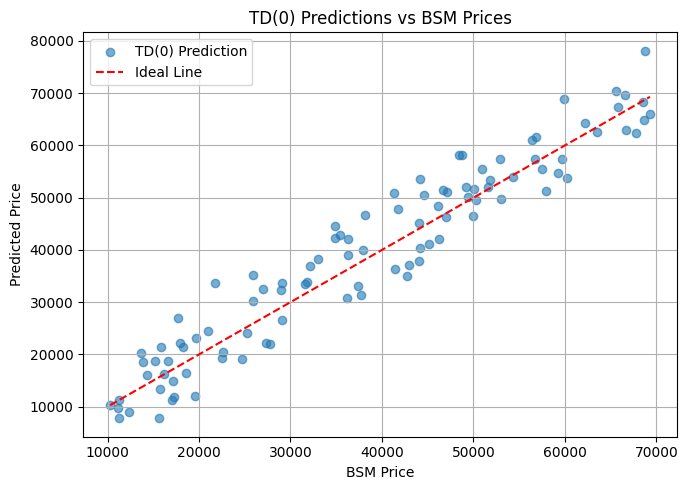

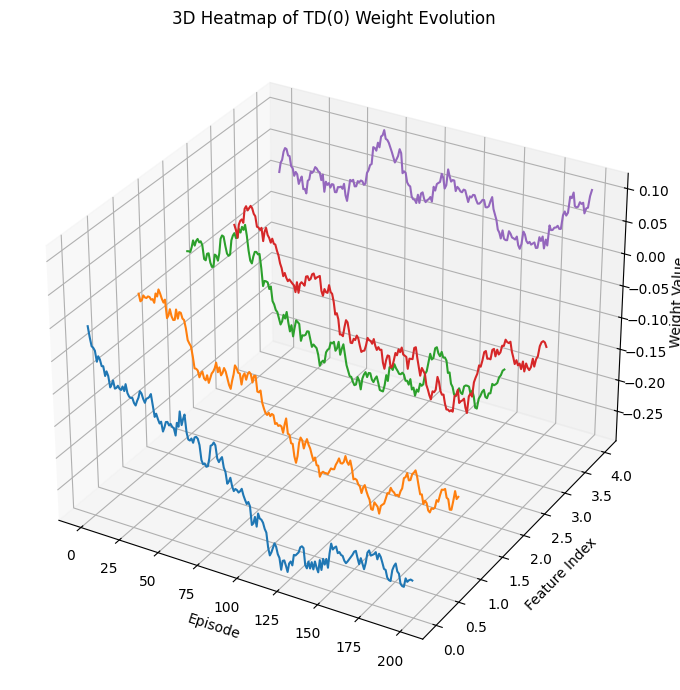

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming weight vectors were learned using the above loops
# These are placeholder vectors (you should replace them with your actual ones from training)
w_reinforce = np.random.uniform(-0.2, 0.2, size=5)
w_baseline = np.random.uniform(-0.2, 0.2, size=5)
w_td = np.random.uniform(-0.2, 0.2, size=5)

features = ['Loan Age', 'FICO', 'Loan Term', 'Interest Rate', 'DTI']

# === 1. Heatmap of Learned Feature Weights ===
df_weights = pd.DataFrame({
    'REINFORCE': w_reinforce,
    'REINFORCE + Baseline': w_baseline,
    'TD(0)': w_td
}, index=features)

plt.figure(figsize=(8, 6))
sns.heatmap(df_weights, annot=True, cmap='coolwarm')
plt.title("Learned Feature Weights by Method")
plt.ylabel("Feature")
plt.xlabel("RL Method")
plt.tight_layout()
plt.show()

# === 2. Simulate Predicted vs BSM Price Scatter Plot (TD) ===
# Assuming these are simulated for illustration
np.random.seed(0)
bsm_prices = np.random.uniform(10000, 70000, size=100)
predicted_td_prices = bsm_prices + np.random.normal(0, 5000, size=100)

plt.figure(figsize=(7, 5))
plt.scatter(bsm_prices, predicted_td_prices, alpha=0.6, label='TD(0) Prediction')
plt.plot([min(bsm_prices), max(bsm_prices)], [min(bsm_prices), max(bsm_prices)], 'r--', label='Ideal Line')
plt.xlabel("BSM Price")
plt.ylabel("Predicted Price")
plt.title("TD(0) Predictions vs BSM Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Simulated 3D Weight Evolution (TD) ===
from mpl_toolkits.mplot3d import Axes3D

# Simulate 200-episode evolution for 5 features
episode_count = 200
weight_history_td = np.cumsum(np.random.normal(0, 0.01, (episode_count, 5)), axis=0)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(5):
    ax.plot(np.arange(episode_count), [i]*episode_count, weight_history_td[:, i], label=features[i])

ax.set_xlabel("Episode")
ax.set_ylabel("Feature Index")
ax.set_zlabel("Weight Value")
ax.set_title("3D Heatmap of TD(0) Weight Evolution")
plt.tight_layout()
plt.show()
